In [103]:
import gspread
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from google.oauth2.service_account import Credentials
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

import hdbscan

In [104]:
SERVICE_ACCOUNT_FILE = 'key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open('AI Summary Tagging').worksheet("negative_word")
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])

### Data Cleaning

In [105]:
df = df.iloc[:, [0, 1, 2, 3, 4, 5]].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    342 non-null    object
 1   Validator               342 non-null    object
 2   Ticket ID               342 non-null    object
 3   AFI                     342 non-null    object
 4   Type                    342 non-null    object
 5   Indikasi Kata Negative  342 non-null    object
dtypes: object(6)
memory usage: 16.2+ KB


In [164]:
df['AFI'] = df['AFI'].replace('','ASI')

TEXT_COL = "Indikasi Kata Negative"

sentences = (
    df.loc[(df['Date'] > '2025-12-1') & (df['Type'].eq('Kalimat')), TEXT_COL]
    .astype(str)
    .str.lower()
    .str.replace(r'[^\w\s]', ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
    .tolist()
)

print("jumlah kalimat: ", len(sentences))
print("Contoh 5 kalimat pertama: ")

for s in random.sample(sentences, min(len(sentences), 5)):
    print("-", s)

jumlah kalimat:  154
Contoh 5 kalimat pertama: 
- kenapa saya tidak bisa menggunakan spayletr
- tagihan pertama saya lewat 2 hari tapi kenapa disuruh lunasi langsung dengan tagihan ke 2
- kendala pembayaran tagihan dana cicil
- hadiah voucher belanja tidak bisa digunakan
- knapa saya cek ktp saya punya hutang di akulaku padahal saya gk pernah minjam


### Model

In [107]:
# Semantic vector
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

embeddings = model.encode(sentences, show_progress_bar=True, convert_to_numpy=True)
embeddings.shape

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

(154, 384)

In [108]:
ex1 = sentences[random.randint(0, len(sentences)-1)]
ex2 = sentences[random.randint(0, len(sentences)-1)]

emb1 = model.encode(ex1, convert_to_numpy=True)
emb2 = model.encode(ex2, convert_to_numpy=True)

sim = util.cos_sim(emb1, emb2).item()
print("Cosine similarity:", round(sim, 3))

print(f"{ex1}\n{ex2}")

Cosine similarity: 0.594
hadeuhh masih muter2 aja udh dikasih tau kerja sebagai ojek online malah dimintain suraht phk cape berhadapan sm org stres
ko saya gabisa minjem ya di akulaku


In [109]:
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.45,
    metric="cosine",
    linkage="average"
)

labels = clustering.fit_predict(embeddings)
len(set(labels)), labels[:20]

(49,
 array([17, 38, 42,  3,  7, 41,  9,  1,  0,  0,  7,  0,  7, 18,  0, 15,  4,
        15,  7, 25]))

In [110]:
print(df.shape)
print(len(labels))

(342, 6)
154


In [111]:
cluster_sentences = df[(df['Date'] > '2025-12-1') & (df['Type'] == 'Kalimat')].reset_index(drop=True)
cluster_sentences['cluster'] = labels

cluster_sentences.sort_values(['cluster']).reset_index(drop=True)

,Date,Validator,Ticket ID,AFI,Type,Indikasi Kata Negative,cluster
0,2025-12-2,Azer,22080660,ASI,Kalimat,Pembayaran Akulaku Paylater tidak sesuai,0
1,2025-12-2,Azer,22078903,ASI,Kalimat,kenapa sudah bayar tetapi masih muncul,0
2,2025-12-2,Aulia,20285647,ASI,Kalimat,ingat saya sudah bayar ya!!,0
3,2025-12-2,Aulia,20561905,ASI,Kalimat,kalau mau saya bayarkan itu ya buang bunganya....,0
4,2025-12-2,Neneng,22476568,ASI,Kalimat,sudah bayar dana cicil namun masih dalam penag...,0
...,...,...,...,...,...,...,...
149,2025-12-5,Reza,21457185,ASI,Kalimat,Denda muncul 2 kali lipat,44
150,2025-12-3,Aulia,20518183,ASI,Kalimat,kalo emang tida bisa meminjam di aplikasi ini ...,45
151,2025-12-2,Reza,22298508,ASI,Kalimat,saya sudah semuanya tetapi tidak diverifikasi,46
152,2025-12-3,Aulia,20531716,ASI,Kalimat,saya minta bantuan ke OJK atau pihak berwajib,47


In [112]:
df.to_csv('negative_word_clustered.csv', index=False)

In [113]:
# The Score

sil_score = silhouette_score(embeddings, labels)
dbi = davies_bouldin_score(embeddings, labels)
ch = calinski_harabasz_score(embeddings, labels)

print(f"{sil_score:.3f} - Silhouette Score")
print(f"{dbi:.3f} - Davies-Bouldin Index")
print(f"{ch:.3f} - Calinski-Harabasz Score")

0.041 - Silhouette Score
0.918 - Davies-Bouldin Index
3.626 - Calinski-Harabasz Score


In [114]:
# PCA
pca = PCA(n_components=40, random_state=42)
X_reduced = pca.fit_transform(embeddings)

In [115]:
# KMeans
scores = {}
for k  in range (2, 15):
    km = KMeans(n_clusters=k, random_state=42)
    labels_k = km.fit_predict(X_reduced)
    scores[k] = silhouette_score(X_reduced, labels_k)

scores

{2: 0.10671419650316238,
 3: 0.12286221235990524,
 4: 0.06438109278678894,
 5: 0.08668608963489532,
 6: 0.0622342973947525,
 7: 0.06453026086091995,
 8: 0.06908364593982697,
 9: 0.03835148736834526,
 10: 0.010705838911235332,
 11: 0.009789867326617241,
 12: 0.013395659625530243,
 13: 0.01824127323925495,
 14: 0.02604338340461254}

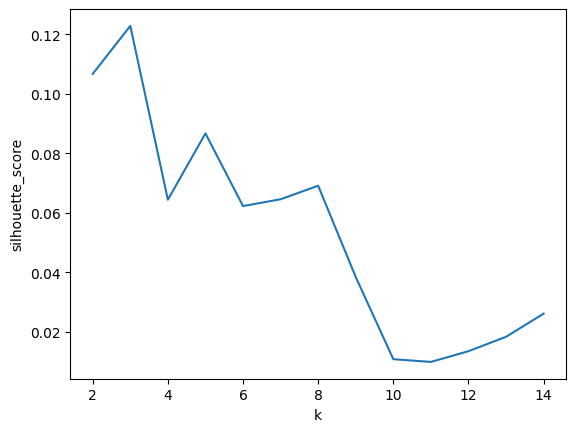

In [116]:
plt.plot(list(scores.keys()), list(scores.values()))
plt.xlabel("k")
plt.ylabel("silhouette_score")
plt.show()

In [117]:
# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, metric='euclidean')
labels = clusterer.fit_predict(X_reduced)

c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [118]:
# Normalize embedding
emb_norm = StandardScaler().fit_transform(embeddings)
emb_norm - normalize(embeddings)

array([[-1.5905889 ,  0.3689625 ,  0.348586  , ..., -1.018488  ,
         0.29968697,  0.7867783 ],
       [-0.07363488,  0.84987307,  0.4829319 , ...,  0.737844  ,
        -0.00749436,  0.3348192 ],
       [ 1.5791621 , -0.97523034,  0.44308174, ...,  2.0603852 ,
        -0.08296016,  1.3942546 ],
       ...,
       [ 0.4557628 ,  1.8815954 ,  0.37264612, ..., -0.44285125,
        -0.10558811, -0.4479225 ],
       [-0.39732295, -0.07552898, -0.5727705 , ..., -0.44622815,
        -0.82738394, -0.9357421 ],
       [ 0.08678874, -0.61068755, -0.25266495, ...,  0.16429168,
         1.3346496 ,  0.08642256]], shape=(154, 384), dtype=float32)

### Visualize

In [119]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=5,
    learning_rate=100
)

tsne_coords = tsne.fit_transform(embeddings)

In [120]:
df_tsne = cluster_sentences.copy().reset_index(drop=True)

assert tsne_coords.shape[0] == len(df_tsne), "Jumlah baris df dan embeddings harus sama"

df_tsne['tsne_x'] = tsne_coords[:, 0]
df_tsne['tsne_y'] = tsne_coords[:, 1]
df_tsne['cluster_id'] = labels

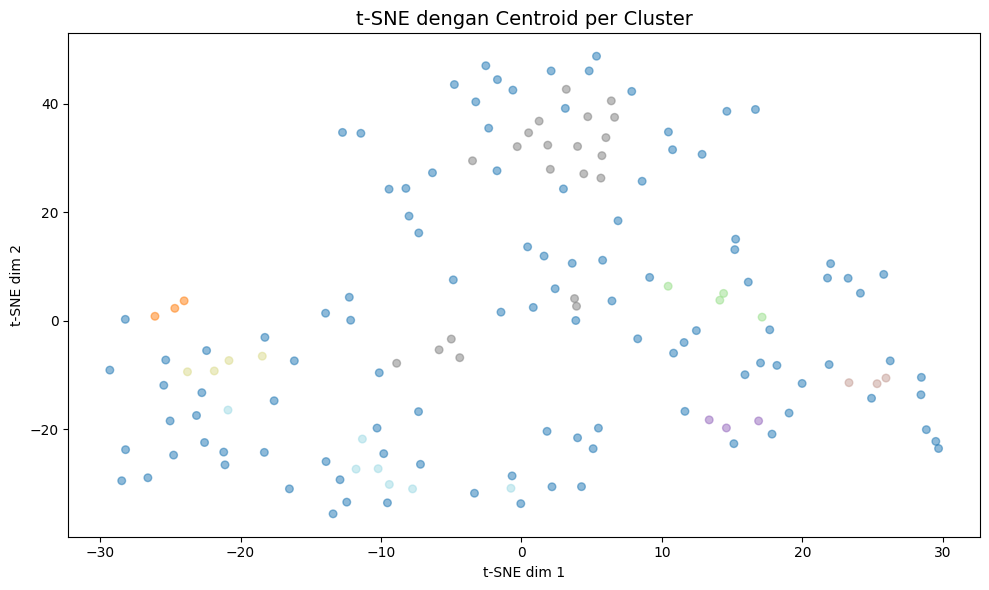

In [121]:
# ===== 5. Tambahkan titik rata-rata per cluster + 1 contoh kalimat =====

unique_clusters = np.unique(labels)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    df_tsne['tsne_x'],
    df_tsne['tsne_y'],
    c=df_tsne['cluster_id'],
    cmap='tab20',
    alpha=0.5,
    s=30
)

for cid in unique_clusters:
    sub = df_tsne[df_tsne['cluster_id'] == cid]
    cx = sub['tsne_x'].mean()
    cy = sub['tsne_y'].mean()
    
    # # plot centroid
    # plt.scatter(cx, cy, edgecolor='black', s=120, marker='X')
    # plt.text(
    #     cx, cy,
    #     f"C{cid}",
    #     fontsize=9,
    #     ha='center',
    #     va='center',
    #     bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7)
    # )

plt.title("t-SNE dengan Centroid per Cluster", fontsize=14)
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


### Model B

In [122]:
X = embeddings
X_norm = normalize(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_norm)

In [123]:
pca = PCA(n_components=40, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Jumlah dimensi setelah PCA:", X_pca.shape[1])
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Jumlah dimensi setelah PCA: 40
Total explained variance: 0.8624191


In [133]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=4,
    min_samples=2,
    metric='euclidean',
    cluster_selection_method='eom'
)

labels = clusterer.fit_predict(X_pca)

cluster_sentences['cluster_id'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Jumlah cluster ditemukan:", n_clusters)

unique, counts = np.unique(labels, return_counts=True)
print("Distribusi cluster:", dict(zip(unique, counts)))

Jumlah cluster ditemukan: 2
Distribusi cluster: {np.int64(-1): np.int64(76), np.int64(0): np.int64(13), np.int64(1): np.int64(65)}


c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [134]:
mask = labels != -1
X_eval = X_pca[mask]
labels_eval = labels[mask]

if mask.sum() > 10 and len(np.unique(labels_eval)) > 1:
    sil = silhouette_score(X_eval, labels_eval)
    dbi = davies_bouldin_score(X_eval, labels_eval)
    ch = calinski_harabasz_score(X_eval, labels_eval)

    print(f"{sil:.3f} - Silhouette Score (no noise)")
    print(f"{dbi:.3f} - Davies-Bouldin Index (no noise)")
    print(f"{ch:.3f} - Calinski-Harabasz Score (no noise)")
else:
    print("Temee")

0.189 - Silhouette Score (no noise)
1.731 - Davies-Bouldin Index (no noise)
12.915 - Calinski-Harabasz Score (no noise)


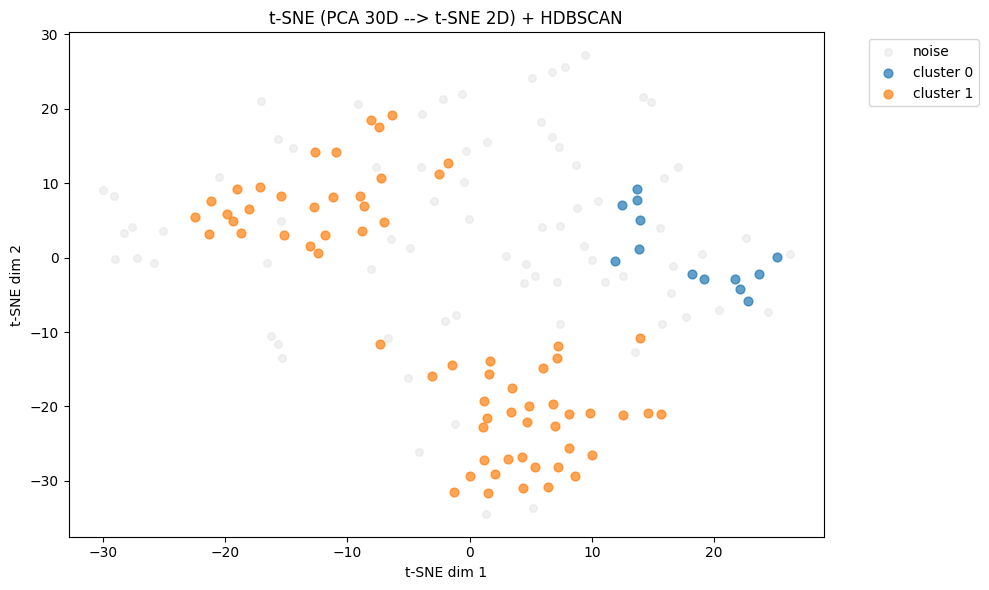

In [135]:
tsne = TSNE(
    n_components=2,
    perplexity=10,
    learning_rate='auto',
    max_iter=1000,
    random_state=42,
    init='random'
)

X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 6))

for cid in np.unique(labels):
    idx = labels == cid
    if cid == -1:
        plt.scatter(
            X_tsne[idx, 0], X_tsne[idx, 1],
            s=30, alpha=0.3, c="lightgray", label="noise"
        )
    else:
        plt.scatter(
            X_tsne[idx, 0], X_tsne[idx, 1],
            s=40, alpha=0.7, label=f"cluster {cid}"
        )

plt.title("t-SNE (PCA 30D --> t-SNE 2D) + HDBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [136]:
def show_examples(cluster_id, n=5, text_col="Indikasi Kata Negative"):
    subset = cluster_sentences[cluster_sentences["cluster_id"] == cluster_id]
    if subset.empty:
        print(f"Tidak ada data untuk cluster {cluster_id}")
        return

    sample = subset.sample(min(n, len(subset)), random_state=42)
    for i, row in sample.iterrows():
        print(f"[{cluster_id}] {row[text_col]}")
    print("-" * 60)

for cid in sorted(c for c in cluster_sentences["cluster_id"].unique() if c != -1):
    print(f"=== Cluster {cid} ===")
    show_examples(cid, n=10)  # sekarang text_col default sudah benar


=== Cluster 0 ===
[0] va bca kok belum ada
[0] skrg sy mau minjem lg ko gaada
[0] nasabah AKULAKU NAMUN SY TDK ADA TUNGGAKAN
[0] kak pesanan saya kok g ada ya
[0] Atau saya lapor ojk aja lah klo lapor disini disuruh ngulang2 lg
[0] kok gk bs pinjm lg kk
[0] mau diganti tp tidak bisa
[0] ko saya gabisa minjem ya di akulaku
[0] hadeh susah amat ya mau bayar di persulit
[0] knpa tdk bisah mnjam lg
------------------------------------------------------------
=== Cluster 1 ===
[1] pinjaman ko lama cair ya
[1] Sudah bayar tagihan, namun tidak bisa pinjaman
[1] tolong sy pusing,sy bilang pinjaman yg sy ajukan belum sy terima
[1] di ovo sudah berhasil tapi tagihannya kok tetep ada kak
[1] Sudah lunasi Pinjaman tapi tagihan muncul
[1] kenapa gak bisa ngajuin pinjaman
[1] kendala ya di tolak trs padahal pinjaman udh lunas
[1] sebelumya saya mau mengajuhkan pinjaman diakulaku tetapi menunggu pending terus tidak di-ACC padahal belum pernah pinjol
[1] knapa saya cek KTP saya punya hutang di Akulaku

In [137]:
show_examples(-1, n=10)
show_examples(0, n=10)
show_examples(1, n=10)

[-1] ini kesalahan dari akulaku nya lambat ,tangganin nyaa
[-1] mengapa saya tidak bisa mengajukan peminjaman?
[-1] tidak ada pilihan untuk bayar melalui BCA
[-1] kuota atau paket yg saya beli blum msuk sampai skrg
[-1] saya mendapatkan teror telepon dari mengaku sebagai DC dari akulaku mengancam akan kerumah
[-1] hari ini saya akan bayar cicilan namun perhitungan tidak sesuai..yg seharusnya 767000..begitu akan direalisasi kenapa menjadi 2x lipat
[-1] Batalkan pengajuan Pinjaman pakai BPKP
[-1] saya telah membayar DP untuk barang HP tetapi belum dikirim juga mohon dikembalikan dp
[-1] tinggal satu biji,lucky draw apaan ini,pelit bget ni aplikasi akulaku
[-1] kok belum masuk uang nya padahal udah lolos verifikasi
------------------------------------------------------------
[0] va bca kok belum ada
[0] skrg sy mau minjem lg ko gaada
[0] nasabah AKULAKU NAMUN SY TDK ADA TUNGGAKAN
[0] kak pesanan saya kok g ada ya
[0] Atau saya lapor ojk aja lah klo lapor disini disuruh ngulang2 lg
[0] kok

In [138]:
labels = cluster_sentences['cluster_id'].values
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(-1): np.int64(76), np.int64(0): np.int64(13), np.int64(1): np.int64(65)}


### Noise Cluster

In [166]:
noise_df = cluster_sentences[cluster_sentences['cluster_id'] == -1].copy()
noise_embeddings = X_pca[labels == -1]

clusterer_noise = hdbscan.HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom'
)

noise_labels = clusterer_noise.fit_predict(noise_embeddings)

c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ozy.prazuganda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [168]:
noise_df['noise_cluster'] = noise_labels

unique, counts = np.unique(noise_labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(-1): np.int64(11), np.int64(0): np.int64(3), np.int64(1): np.int64(62)}


In [169]:
def show_noise_cluster(cid, n=10, text_col="Indikasi Kata Negative"):
    subset = noise_df[noise_df["noise_cluster"] == cid]
    if subset.empty:
        print(f"no noise {cid}")
        return
    sample = subset.sample(min(n, len(subset)), random_state=42)
    for i, row in sample.iterrows():
        print(f"[{cid}] {row[text_col]}")
    print("-" * 60)

for cid in sorted(c for c in noise_df['noise_cluster'].unique()):
    print(f"=== Noise Cluster {cid} ===")
    show_noise_cluster(cid, n=10)

=== Noise Cluster -1 ===
[-1] hadeuhh masih muter2 aja, udh dikasih tau kerja sebagai ojek online malah dimintain suraht phk, cape berhadapan sm org stres
[-1] gak ada pengaruh sama aja jawabannya ganti" cs dari kemarin sama aja gk bakal ada perubahan apk gak nyaman untuk pinjol
[-1] Paket data tidak bisa digunakan
[-1] tidak pernah terlambat, limit tidak naik
[-1] Masalah akan diviralkan ke media
[-1] aplikasinya tidak ramah untuk customer/pengguna
[-1] jadi gx bisa pinjam lagi
[-1] roda hadiah 300rb php ya?
[-1] sudah 4 bulan lebih belum pernah di acc
[-1] paylater ga bisa di pakai
------------------------------------------------------------
=== Noise Cluster 0 ===
[0] saya juga bisa buat laporan atas masalah ini
[0] informasi sudah jelas dan itu harus bikin" laporan/ dukumen kurang ribet bang
[0] sudah dapet email dari akulaku tapi blon ada perkembangan
------------------------------------------------------------
=== Noise Cluster 1 ===
[1] Barang sudah diretur, tagihan muncul
[1] K

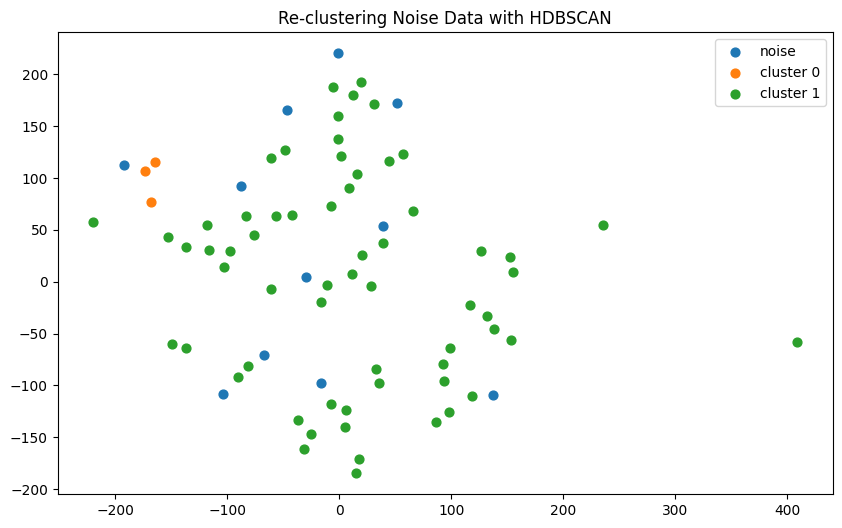

In [170]:
tsne_noise = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate=100,
    max_iter=1000,
    random_state=42
)

tsne_noise_emb = tsne_noise.fit_transform(noise_embeddings)

plt.figure(figsize=(10, 6))
for cid in np.unique(noise_labels):
    idx = noise_labels == cid
    plt.scatter(
        tsne_noise_emb[idx, 0],
        tsne_noise_emb[idx, 1],
        s=40,
        label=f"cluster {cid}" if cid != -1 else "noise"
    )

plt.legend()
plt.title('Re-clustering Noise Data with HDBSCAN')
plt.show()

### Final Taxonomy

In [182]:
def assign_label(row):
    # Step 1
    if row['cluster_id'] == 0:
        return "(Cluster A) Masalah Pengajuan/Akses Pinjam"
    if row['cluster_id'] == 1:
        return "(Cluster B) Masalah Tagihan & Pembayaran"
    
    # Step 2
    if row['cluster_id'] == -1:
        if row.get('noise_cluster') == 1:
            return "(Cluster C) Masalah Sistem & Fitur Aplikasi"
        if row.get('noise_cluster') == 0:
            return '(Cluster D) Masalah Laporan/Investigasi'
        
        return '(Cluster Noise) Keluhan Umum/Noise'
    
    # Fallback
    return 'Unknown'

cluster_sentences['label'] = cluster_sentences.apply(assign_label, axis=1)
cluster_sentences[['Indikasi Kata Negative', 'label']].head(20)

,Indikasi Kata Negative,label
0,kuota atau paket yg saya beli blum msuk sampai...,(Cluster C) Masalah Sistem & Fitur Aplikasi
1,kemaren saya bayar Wifi pakai akulaku deskrips...,(Cluster C) Masalah Sistem & Fitur Aplikasi
2,kenapa lokasinya gagal terus ya,(Cluster C) Masalah Sistem & Fitur Aplikasi
3,nasabah AKULAKU NAMUN SY TDK ADA TUNGGAKAN,(Cluster A) Masalah Pengajuan/Akses Pinjam
4,"tolong sy pusing,sy bilang pinjaman yg sy ajuk...",(Cluster B) Masalah Tagihan & Pembayaran
5,"gak ada pengaruh sama aja jawabannya ganti"" cs...",(Cluster Noise) Keluhan Umum/Noise
6,"ini kesalahan dari akulaku nya lambat ,tanggan...",(Cluster C) Masalah Sistem & Fitur Aplikasi
7,saya juga bisa buat laporan atas masalah ini,(Cluster D) Masalah Laporan/Investigasi
8,kalau mau saya bayarkan itu ya buang bunganya....,(Cluster B) Masalah Tagihan & Pembayaran
9,ingat saya sudah bayar ya!!,(Cluster B) Masalah Tagihan & Pembayaran


### Merge

In [183]:
cluster_sentences.loc[cluster_sentences['cluster_id'] == -1, 'noise_cluster'] = noise_df['noise_cluster'].values

cluster_sentences['label'] = cluster_sentences.apply(assign_label, axis=1)
cluster_sentences['label'].value_counts()

label
(Cluster B) Masalah Tagihan & Pembayaran       65
(Cluster C) Masalah Sistem & Fitur Aplikasi    62
(Cluster A) Masalah Pengajuan/Akses Pinjam     13
(Cluster Noise) Keluhan Umum/Noise             11
(Cluster D) Masalah Laporan/Investigasi         3
Name: count, dtype: int64

In [ ]:
cluster_sentences['label'].value_counts()

label
(Cluster B) Masalah Tagihan & Pembayaran       65
(Cluster C) Masalah Sistem & Fitur Aplikasi    62
(Cluster A) Masalah Pengajuan/Akses Pinjam     13
(Cluster Noise) Keluhan Umum/Noise             11
(Cluster D) Masalah Laporan/Investigasi         3
Name: count, dtype: int64

In [ ]:
for i in (65,62,13,11,3):
    print(round(i * 0.25))

16
16
3
3
1


In [ ]:
cluster_sentences.to_csv('negative_word_labeled.csv', index=False)

: 